In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Bidirectional, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
data = pd.read_csv("D:\\4TH YEAR\\FYP\\taasha\\real_BABY.csv")

In [4]:
data['voltage_current_ratio'] = data['volData'] / (data['currentData'] + 1e-6) 
data['power'] = data['volData'] * data['currentData']

In [5]:
input_features = ["Timestamp" , "volData" , "currentData"]
output_features = ['batTempData','socData','sohData','motTempData','speedData']

In [6]:
x = data[input_features].values
y = data[output_features].values

In [7]:
def remove_outliers(data):
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask = np.all((data >= lower_bound) & (data <= upper_bound), axis=1)
    return data[mask], mask

x_cleaned, mask = remove_outliers(x)
y_cleaned = y[mask]

In [8]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_scaled = scaler_x.fit_transform(x_cleaned)
y_scaled = scaler_y.fit_transform(y_cleaned)

In [9]:
def create_sequences(x, y, sequence_length=20, stride=1): 
    x_seq, y_seq = [], []
    for i in range(0, len(x) - sequence_length, stride):
        x_seq.append(x[i:i + sequence_length])
        y_seq.append(y[i + sequence_length - 1])  
    return np.array(x_seq), np.array(y_seq)

sequence_length = 20
x_sequences, y_sequences = create_sequences(x_scaled, y_scaled, sequence_length)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    x_sequences, y_sequences, test_size=0.3, random_state=42)

In [11]:
model = Sequential([
    Bidirectional(GRU(512, return_sequences=True,kernel_initializer='glorot_uniform',recurrent_dropout=0.1), input_shape=(sequence_length, x_train.shape[2])),
    LayerNormalization(),
    Dropout(0.3),

    Bidirectional(GRU(384, return_sequences=True, kernel_initializer='glorot_uniform',recurrent_dropout=0.1)),
    LayerNormalization(),
    Dropout(0.3),

    Bidirectional(GRU(256, return_sequences=False,kernel_initializer='glorot_uniform',recurrent_dropout=0.1)),
    LayerNormalization(),
    Dropout(0.3),

    Dense(512, activation='selu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='selu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='selu'),
    BatchNormalization(),

    Dense(len(output_features), activation='linear')
])


c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate
)

In [13]:
model.compile(optimizer='adam', loss='huber', metrics=['mae', 'mse'])

In [14]:
early_stopping = EarlyStopping(monitor='val_loss',patience=30,restore_best_weights=True,verbose=1
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=15,min_lr=1e-6,verbose=1
)

In [15]:
history = model.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2, verbose=1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 717ms/step - loss: 0.9801 - mae: 1.3992 - mse: 3.3664 - val_loss: 1.2548 - val_mae: 1.6933 - val_mse: 4.3989
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - loss: 0.6027 - mae: 0.9915 - mse: 1.7858 - val_loss: 1.3676 - val_mae: 1.8127 - val_mse: 4.8448
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - loss: 0.4896 - mae: 0.8629 - mse: 1.4046 - val_loss: 1.5179 - val_mae: 1.9667 - val_mse: 5.6991
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - loss: 0.4111 - mae: 0.7659 - mse: 1.1904 - val_loss: 1.6358 - val_mae: 2.0921 - val_mse: 6.4281
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - loss: 0.3909 - mae: 0.7369 - mse: 1.1307 - val_loss: 1.6927 - val_mae: 2.1484 - val_mse: 6.4396
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - loss: 0.3566 - mae: 0.6909 - mse: 1.0344 - val_loss: 1.6916 - val_mae: 2.1548 - val_mse: 6.6156
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - loss: 0.3370 - mae: 0.6604 - mse: 1.0169 - val_loss: 1.5719

In [16]:
test_loss, test_mae, test_mse = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {np.sqrt(test_mse):.4f}")


Test Loss: 0.2046
Test MAE: 0.4621
Test MSE: 0.5486
Test RMSE: 0.7407


In [17]:
y_pred_scaled = model.predict(x_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step


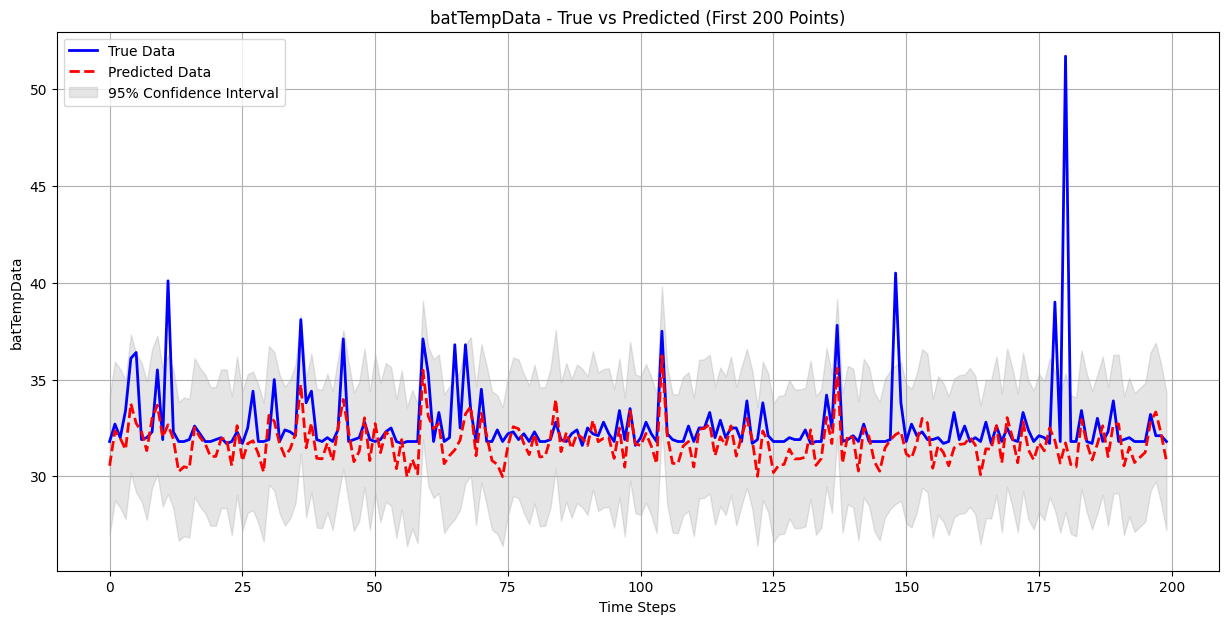


Metrics for batTempData:
MAE: 1.1028
RMSE: 2.0148
R² Score: -0.0315
Accuracy: 96.81%


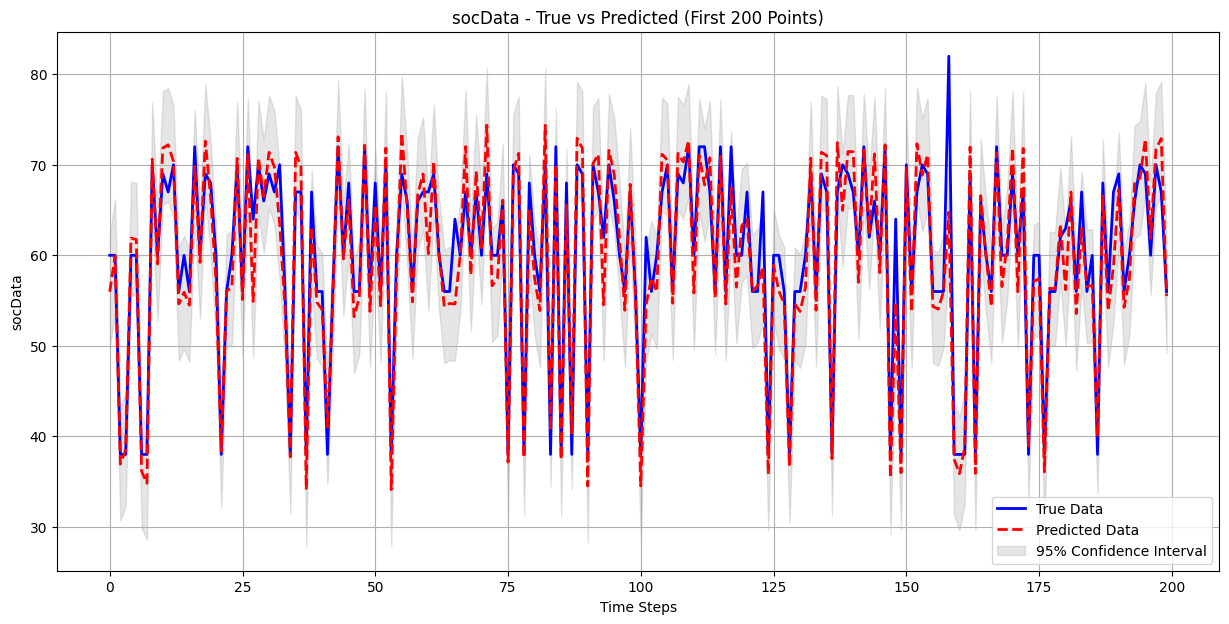


Metrics for socData:
MAE: 2.3987
RMSE: 3.1921
R² Score: 0.9037
Accuracy: 96.02%


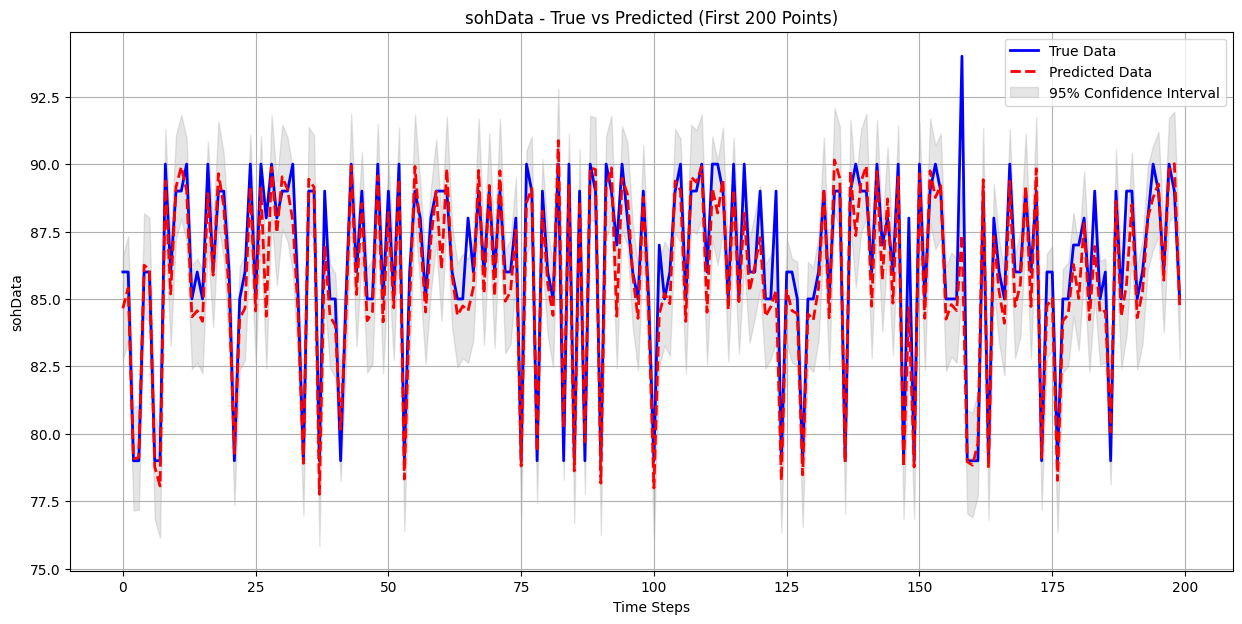


Metrics for sohData:
MAE: 0.8006
RMSE: 1.1091
R² Score: 0.8960
Accuracy: 99.08%


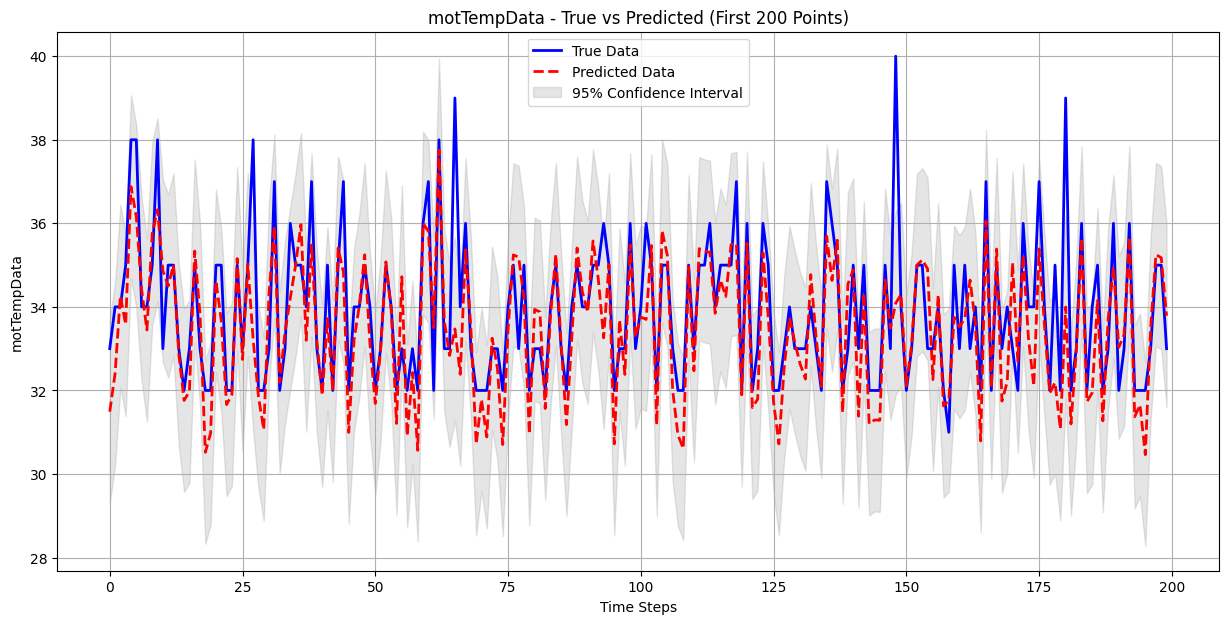


Metrics for motTempData:
MAE: 0.8144
RMSE: 1.1750
R² Score: 0.5242
Accuracy: 97.64%


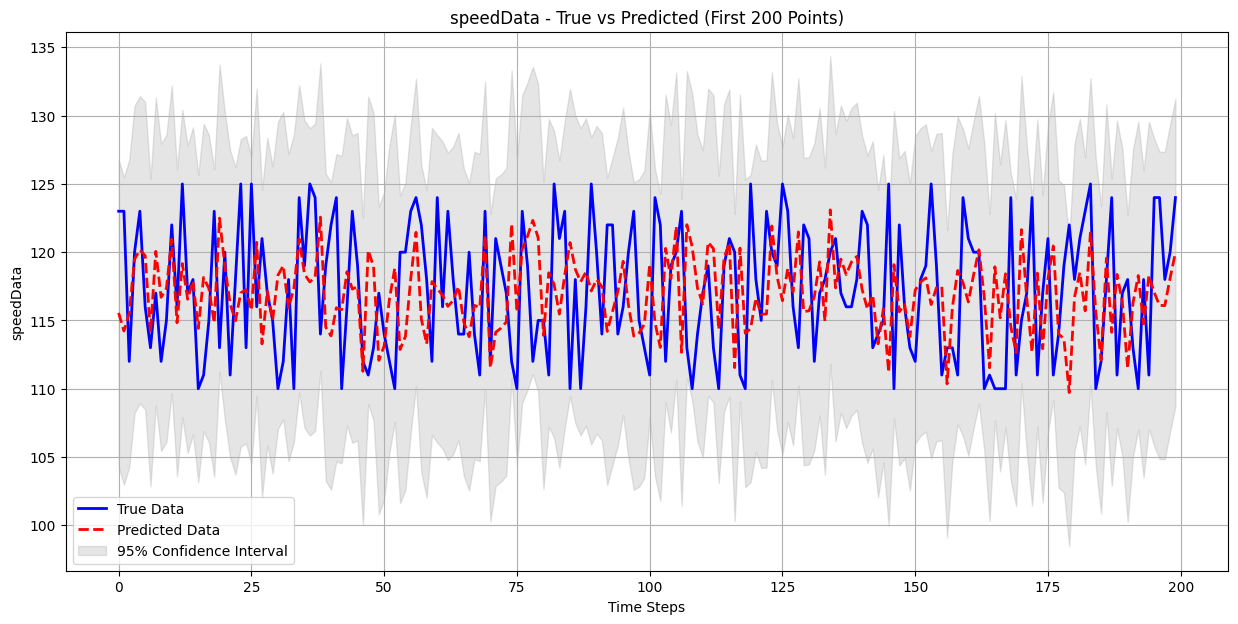


Metrics for speedData:
MAE: 4.6575
RMSE: 5.6404
R² Score: -0.4061
Accuracy: 96.03%

Overall Model Performance:
Overall MAE: 1.9548
Overall RMSE: 2.6263
Overall R² Score: 0.3773
Overall Accuracy: 97.12%


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score

total_mae = 0
total_rmse = 0
total_r2 = 0
total_mape = 0
num_features = len(output_features)

for i, feature in enumerate(output_features):
    plt.figure(figsize=(15, 7))

    residuals = y_true[:, i] - y_pred[:, i]
    std_residuals = np.std(residuals)

    plt.plot(y_true[:200, i], 'b-', label='True Data', linewidth=2)
    plt.plot(y_pred[:200, i], 'r--', label='Predicted Data', linewidth=2)
    plt.fill_between(range(200),
                     y_pred[:200, i] - 2 * std_residuals,
                     y_pred[:200, i] + 2 * std_residuals,
                     color='gray', alpha=0.2,
                     label='95% Confidence Interval')

    plt.title(f'{feature} - True vs Predicted (First 200 Points)')
    plt.xlabel('Time Steps')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.show()

    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    rmse = np.sqrt(np.mean((y_true[:, i] - y_pred[:, i]) ** 2))
    r2 = r2_score(y_true[:, i], y_pred[:, i])
    mape = mean_absolute_percentage_error(y_true[:, i], y_pred[:, i]) * 100
    accuracy = 100 - mape

    print(f"\nMetrics for {feature}:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")

    total_mae += mae
    total_rmse += rmse
    total_r2 += r2
    total_mape += mape

overall_mae = total_mae / num_features
overall_rmse = total_rmse / num_features
overall_r2 = total_r2 / num_features
overall_accuracy = 100 - (total_mape / num_features)

print("\nOverall Model Performance:")
print(f"Overall MAE: {overall_mae:.4f}")
print(f"Overall RMSE: {overall_rmse:.4f}")
print(f"Overall R² Score: {overall_r2:.4f}")
print(f"Overall Accuracy: {overall_accuracy:.2f}%")


In [19]:
model.save('GRU_nn_rial.h5')
model.save_weights('GRU_model_rial.weights.h5')

In [21]:
import numpy as np

def predict_sequence(input_sequence):
    if input_sequence.shape[0] != sequence_length:
        raise ValueError(f"Input sequence must have length {sequence_length}")

    input_scaled = scaler_x.transform(input_sequence)
    input_scaled = input_scaled.reshape(1, sequence_length, -1)

    pred_scaled = model.predict(input_scaled, verbose=0)
    prediction = scaler_y.inverse_transform(pred_scaled)

    return prediction[0]

sample_input = np.random.rand(sequence_length, 3)  

sample_input[0] = [0, 3.85, 0.2900]  

predicted_values = predict_sequence(sample_input)

print("\nPredictions for input:")
for i, entry in enumerate(sample_input):
    print(f"Sample {i + 1}: {entry}")

print("\nPredicted Values:")
for feature, value in zip(output_features, predicted_values):
    print(f"{feature}: {value:.4f}")



Predictions for input:
Sample 1: [0.   3.85 0.29]
Sample 2: [0.35675333 0.28093451 0.54269608]
Sample 3: [0.14092422 0.80219698 0.07455064]
Sample 4: [0.98688694 0.77224477 0.19871568]
Sample 5: [0.00552212 0.81546143 0.70685734]
Sample 6: [0.72900717 0.77127035 0.07404465]
Sample 7: [0.35846573 0.11586906 0.86310343]
Sample 8: [0.62329813 0.33089802 0.06355835]
Sample 9: [0.31098232 0.32518332 0.72960618]
Sample 10: [0.63755747 0.88721274 0.47221493]
Sample 11: [0.11959425 0.71324479 0.76078505]
Sample 12: [0.5612772  0.77096718 0.4937956 ]
Sample 13: [0.52273283 0.42754102 0.02541913]
Sample 14: [0.10789143 0.03142919 0.63641041]
Sample 15: [0.31435598 0.50857069 0.90756647]
Sample 16: [0.24929223 0.41038292 0.75555114]
Sample 17: [0.22879817 0.07697991 0.28975145]
Sample 18: [0.16122129 0.92969765 0.80812038]
Sample 19: [0.63340376 0.87146059 0.80367208]
Sample 20: [0.18657006 0.892559   0.53934224]

Predicted Values:
batTempData: 34.6292
socData: 60.1213
sohData: 84.9997
motTempDa